<h1><center>Naive Bayes - Titanic survival</center></h1>
<h2><center>Probabilistic Machine Learning</center></h2>
<img src="https://embedwistia-a.akamaihd.net/deliveries/f3d4e9ac9dbffd8ad349262f30cffada0a41f4af.jpg" width="600">

#### What are Bayesian Networks?
* In general, Bayesian Networks (BNs) is a framework for reasoning under uncertainty using probabilities. More formally, a BN is defined as a Directed Acyclic Graph (DAG) and a set of Conditional Probability Tables (CPTs). In practice, a problem domain is initially modeled as a DAG.
* Naive Bayes assumes that the variables are independent and comes from a Gaussian distribution.

#### The Bayes theorem
<img src="https://i0.wp.com/scienceprog.com/wp-content/uploads/2016/07/Thomas_Bayes.png?fit=468%2C308&ssl=1" width="400">
* P(A|B) is the posterior probability of class (A, target) given predictor (B,  attributes).
* P(A) is the prior probability of class.
* P(B|A) is the likelihood which is the probability of predictor given class.
* P(B) is the prior probability of predictor.

### Now let's apply this knowledge by building a Naive Bayes model on this data set.

### Dependencies

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score

%matplotlib inline
# Suppress warnings
warnings.filterwarnings("ignore")

### Auxiliary functions

In [2]:
def cross_validate(estimator, train, validation):
    X_train = train[0]
    Y_train = train[1]
    X_val = validation[0]
    Y_val = validation[1]
    train_predictions = classifier.predict(X_train)
    train_accuracy = accuracy_score(train_predictions, Y_train)
    train_recall = recall_score(train_predictions, Y_train)
    train_precision = precision_score(train_predictions, Y_train)

    val_predictions = classifier.predict(X_val)
    val_accuracy = accuracy_score(val_predictions, Y_val)
    val_recall = recall_score(val_predictions, Y_val)
    val_precision = precision_score(val_predictions, Y_val)

    print('Model metrics')
    print('Accuracy  Train: %.2f, Validation: %.2f' % (train_accuracy, val_accuracy))
    print('Recall    Train: %.2f, Validation: %.2f' % (train_recall, val_recall))
    print('Precision Train: %.2f, Validation: %.2f' % (train_precision, val_precision))

### Load data

In [3]:
train_raw = pd.read_csv('../input/train.csv')
test_raw = pd.read_csv('../input/test.csv')
test_ids = test_raw['PassengerId'].values

# Join data to analyse and process the set as one.
train_raw['train'] = 1
test_raw['train'] = 0
data = train_raw.append(test_raw, sort=False)

### Overview the data

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [5]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479,0.680672
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668,0.466394
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000,1.000000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000


One advantage of Bayesian models is that it works well enough with small data, having more would give you more accurate probabilities but it's not data hungry as something like deep learning.

### Pre-process
* feature selection, data cleaning, feature engineering and data imputation

In [6]:
features = ['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp']
target = 'Survived'

data = data[features + [target] + ['train']]
# Categorical values need to be transformed into numeric.
data['Sex'] = data['Sex'].replace(["female", "male"], [0, 1])
data['Embarked'] = data['Embarked'].replace(['S', 'C', 'Q'], [1, 2, 3])
data['Age'] = pd.qcut(data['Age'], 10, labels=False)

In [7]:
# Split data into train and test.
train = data.query('train == 1')
test = data.query('train == 0')
# Drop missing values from the train set.
train.dropna(axis=0, inplace=True)
labels = train[target].values

Our processed train set

In [8]:
train.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,train
0,2.0,1.0,7.2500,0,3,1,1,0.0,1
1,7.0,2.0,71.2833,0,1,0,1,1.0,1
2,4.0,1.0,7.9250,0,3,0,0,1.0,1
3,6.0,1.0,53.1000,0,1,0,1,1.0,1
4,6.0,1.0,8.0500,0,3,1,0,0.0,1


### Correlation study
* As we saw Naive Bayes models expect the features to be independent, so let's apply the Pearson correlation coefficient on them to give us a hint about how independent they are from the others.

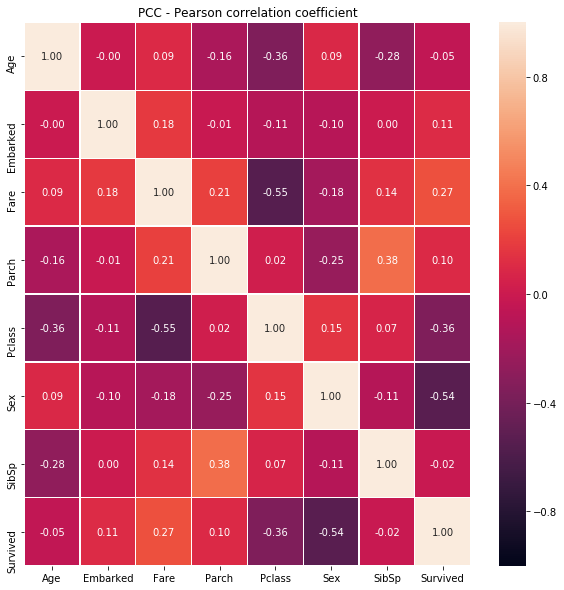

In [9]:
columns = train[features + [target]].columns.tolist()
nColumns = len(columns)
result = pd.DataFrame(np.zeros((nColumns, nColumns)), columns=columns)

# Apply Pearson correlation on each pair of features.
for col_a in range(nColumns):
    for col_b in range(nColumns):
        result.iloc[[col_a], [col_b]] = pearsonr(train.loc[:, columns[col_a]], train.loc[:,  columns[col_b]])[0]
        
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(result, yticklabels=columns, vmin=-1, vmax=1, annot=True, fmt='.2f', linewidths=.2)
ax.set_title('PCC - Pearson correlation coefficient')
plt.show()

About the correlation between the features, we can see that "Fare" and "Pclass" seem to be highly related, so i'll remove "Pclass". Also features like "Sex", "Pclass" and "Fare" should be good predictors.

### Distribution study
* Also the model expect the features to come from a Gaussian (or normal) distribution, so let's check that as well.

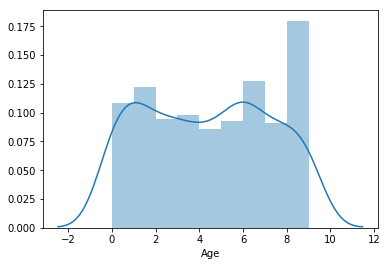

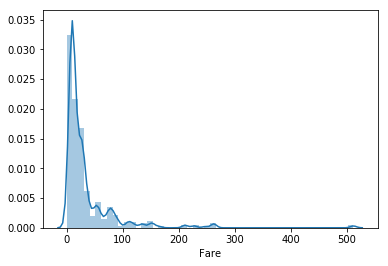

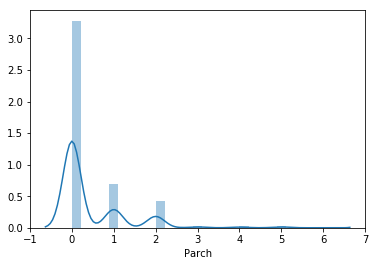

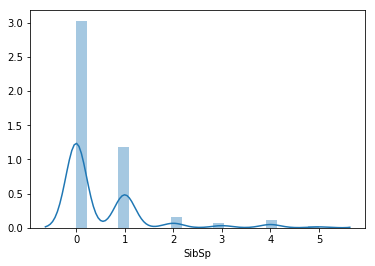

In [10]:
continuous_numeric_features = ['Age', 'Fare', 'Parch', 'SibSp']
for feature in continuous_numeric_features:
    sns.distplot(train[feature])
    plt.show()

Looking at our continuous numeric features we can see that "Fare", "Parch" and "SibSp", have a distribution close to normal, but with a left side skew, "Age" have a distribution a a bit different from the other but maybe it's close enough to Gaussian.

In [11]:
train.drop(['train', target, 'Pclass'], axis=1, inplace=True)
test.drop(['train', target, 'Pclass'], axis=1, inplace=True)

### Split data in train and validation (80% ~ 20%)

In [12]:
X_train, X_val, Y_train, Y_val = train_test_split(train, labels, test_size=0.2, random_state=1)

In [13]:
X_train.head()

,Age,Embarked,Fare,Parch,Sex,SibSp
830,1.0,2.0,14.4542,0,0,1
566,1.0,1.0,7.8958,0,1,0
149,7.0,1.0,13.0000,0,1,0
106,2.0,1.0,7.6500,0,0,0
290,4.0,1.0,78.8500,0,0,0


### Split train data into two parts

In [14]:
X_train1, X_train2, Y_train1, Y_train2 = train_test_split(X_train, Y_train, test_size=0.3, random_state=12)

### Naive Bayes classifier

#### This image may help to understand how a simple Bayesian model works.
![Example of Bayes theorem aplication](http://users.sussex.ac.uk/~christ/crs/kr-ist/copied-pics/humidity-bayesian-network.png)
* Given that we have sun, rain and temperature events and we want to predict if will be humid or not, the probability of being humid will be calculated from the other given events ant theirs probabilities.
* In the boxes we have "sun" as a independent event, "rain" and "temp" as events that depends from "sun" and finally "humid" that depends from all the other.
* In the lower right text, we have the probability of "humid" being yes or no given that "sun" = yes (sun = 100%), so given that is sunny we have 46% probability of being humid and 54% probability of not being humid.

#### How Naive Bayes algorithm works?
* Convert the data set into a frequency table
* Create Likelihood table by finding the probabilities.
* Now, use Naive Bayesian equation to calculate the posterior probability for each class. The class with the highest posterior probability is the outcome of prediction.


##### As you can see the whole model is built upon the probabilities of events, that would be our features.

In [15]:
classifier = GaussianNB()

#### Fit the first part
* Fitting data here is really fast.

In [16]:
classifier.fit(X_train2, Y_train2)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
print('Metrics with only 30% of train data')
cross_validate(classifier, (X_train, Y_train), (X_val, Y_val))

Metrics with only 30% of train data
Model metrics
Accuracy  Train: 0.79, Validation: 0.76
Recall    Train: 0.75, Validation: 0.71
Precision Train: 0.71, Validation: 0.71


#### Update the model with the second part
* Nice thing about this kind of model, you can update it by just fitting the model again with more data.

In [ ]:
classifier.partial_fit(X_train1, Y_train1)

In [ ]:
print('Metrics with the remaining 70% of train data')
cross_validate(classifier, (X_train, Y_train), (X_val, Y_val))

As you can see our results improved after we updated  the model with the remaining data.

The sklearn model also give us some interesting options from the model API about the target class.

In [ ]:
print('Probability of each class')
print('Survive = 0: %.2f' % classifier.class_prior_[0])
print('Survive = 1: %.2f' % classifier.class_prior_[1])

In [ ]:
print('Mean of each feature per class')
print('               Age         Embarked   Fare         Parch       Sex         SibSp')
print('Survive = 0: %s' % classifier.theta_[0])
print('Survive = 1: %s' % classifier.theta_[1])

In [ ]:
print('Variance of each feature per class')
print('Survive = 0: %s' % classifier.sigma_[0])
print('Survive = 1: %s' % classifier.sigma_[1])

### Apply the model on the test data and create submission

In [ ]:
# Unfortunately sklearn naive Bayes algorithm currently do not make inference with missing data (but should do), so we need to input missing data.
test.fillna(test.mean(), inplace=True)
test_predictions = classifier.predict(test)
submission = pd.DataFrame({'PassengerId': test_ids})
submission['Survived'] = test_predictions.astype('int')
submission.to_csv('submission.csv', index=False)
submission.head(10)

### What are the Pros and Cons of Naive Bayes?
#### Pros:
* Humans are not good with reasoning in systems with limited or conflicting information. It would be handy if we have something to manage all this limited/conflicting information.
* It is easy and fast to predict class of test data set. It also perform well in multi class prediction
* When assumption of independence holds, a Naive Bayes classifier performs better compare to other models like logistic regression and you need less training data.
* It perform well in case of categorical input variables compared to numerical variable(s). For numerical variable, normal distribution is assumed (bell curve, which is a strong assumption).

#### Cons:
* Probably the most notable weakness of BNs is the designing methodology.There is no standard way of building BNs.
* If categorical variable has a category (in test data set), which was not observed in training data set, then model will assign a 0 (zero) probability and will be unable to make a prediction. This is often known as “Zero Frequency”. To solve this, we can use the smoothing technique. One of the simplest smoothing techniques is called Laplace estimation.
* On the other side naive Bayes is also known as a bad estimator, so the probability outputs from predict_proba are not to be taken too seriously.
* Another limitation of Naive Bayes is the assumption of independent predictors. In real life, it is almost impossible that we get a set of predictors which are completely independent.

##### The design of a BN can be a considerable amount of effort in complex systems and it is based on the knowledge of the expert(s) who designed it. Although, this disadvantage can be good in another point of view, since BNs can be easily inspected by the designers and has the guarantee that the domain specific information is being used.

### Tips to improve the power of Naive Bayes Model
#### Here are some tips for improving power of Naive Bayes Model:

* If continuous features do not have normal distribution, we should use transformation or different methods to convert it in normal distribution.
* If test data set has zero frequency issue, apply smoothing techniques “Laplace Correction” to predict the class of test data set.
* Remove correlated features, as the highly correlated features are voted twice in the model and it can lead to over inflating importance.
* Naive Bayes classifiers has limited options for parameter tuning like alpha=1 for smoothing, fit_prior=[True|False] to learn class prior probabilities or not and some other options (look at detail here). I would recommend to focus on your  pre-processing of data and the feature selection.
* You might think to apply some classifier combination technique like ensembling, bagging and boosting but these methods would not help. Actually, “ensembling, boosting, bagging” won’t help since their purpose is to reduce variance. Naive Bayes has no variance to minimize.


### References
* [Introduction to Bayesian Networks with Jhonatan de Souza Oliveira - Machine Learning Mastery](https://machinelearningmastery.com/introduction-to-bayesian-networks-with-jhonatan-de-souza-oliveira/)
* [6 Easy Steps to Learn Naive Bayes Algorithm (with codes in Python and R) - Analytics Vidhya](https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/)
* [Better Naive Bayes: 12 Tips To Get The Most From The Naive Bayes Algorithm - Machine Learning Mastery](https://machinelearningmastery.com/better-naive-bayes/)